In [62]:
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from keras.datasets import mnist
from keras.utils import np_utils
from scipy import signal

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

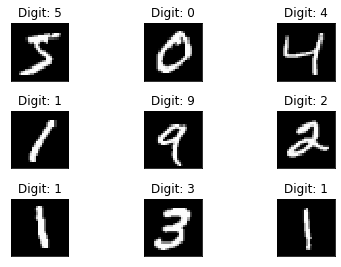

In [ ]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
y_train.shape

(60000,)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28) 
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28) 
input_shape = (1, 28, 28) 


x_train = x_train.astype('float32')
x_test = x_test.astype('float32') 
x_train /= 255 
x_test /= 255 

In [ ]:
y_train.shape[0]

60000

In [ ]:
y_train = np_utils.to_categorical(y_train)

In [ ]:
y_train = y_train.reshape(y_train.shape[0], 10, 1)

In [ ]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

In [ ]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [ ]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)
        
class Relu(Activation):
    def __init__(self):
        def relu(x):
            return x * (x > 0)

        def relu_prime(x):
            return 1. * (x > 0)

        super().__init__(relu, relu_prime)


In [ ]:
class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)

In [ ]:
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

In [ ]:
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)

        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

In [ ]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        # self.weights = np.random.randn(output_size, input_size)
        # self.bias = np.random.randn(output_size, 1)

        self.weights = np.random.uniform(-1, 1, (output_size, input_size)) 
        self.bias = np.random.uniform(1, 0, (output_size, 1))

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input, out=None) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [ ]:
def mse(y_true, y_pred):
    # print(f"y_true:{y_true}")
    # print(f"y_pred:{y_pred}")
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

In [ ]:
def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [ ]:
def cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred))

def cross_entropy_prime(y_true, y_pred):
    return y_pred - y_true

In [ ]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def figure(errors):
    fig = plt.figure()
    ax = plt.axes()
    ax.plot([i + 1 for i in range(0, len(errors), 1)], errors, color='#F27719', label = 'loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

def train(network, loss, loss_prime, x_train, y_train, x_test, y_test, epochs = 1000, learning_rate = 0.01, verbose = True):
    errors = list()
    for e in range(epochs):
        error = count = 0
        answer = []
        for x, y in zip(x_train, y_train):

            output = predict(network, x)

            error += loss(y, output)

          # backward
            grad = loss_prime(y, output)
            
            for layer in reversed(network):
                  grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        errors.append(error)

        # for i in testX:
        #   z =  predict(network, i.reshape(22, 1))
        #   answer.append(np.argmax(z))
        # for i, j in zip(answer, testY):
        #   if i == j:
        #     count += 1

        if verbose:
            print(f"{e + 1}/{epochs}, loss={error}")
        figure(errors)

In [ ]:
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 10),
    Softmax()
]


1/20, loss=0.3280939559275686
2/20, loss=0.35097499357706063
3/20, loss=0.35220195136080135
4/20, loss=0.33127414128269494
5/20, loss=0.31464993625594107
6/20, loss=0.3000941944268583
7/20, loss=0.2852621383560639
8/20, loss=0.26913693287415313
9/20, loss=0.2556046202195314
10/20, loss=0.2486360701207956
11/20, loss=0.2441359950107481
12/20, loss=0.23959839255132895
13/20, loss=0.23471993689679696
14/20, loss=0.22944591080167762
15/20, loss=0.22363402622227319
16/20, loss=0.21713169274603553
17/20, loss=0.21001733414332488
18/20, loss=0.2038944722570192
19/20, loss=0.1992049410284917
20/20, loss=0.19517339190927563


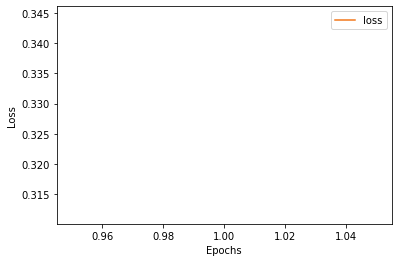

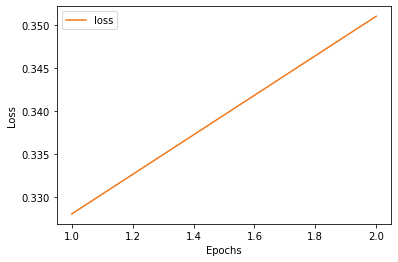

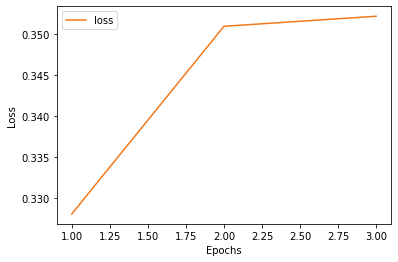

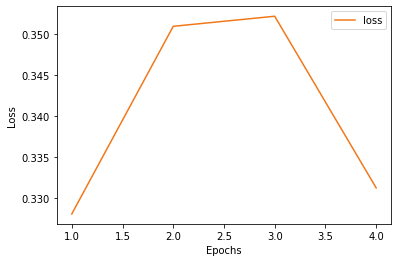

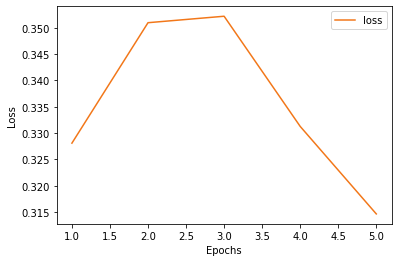

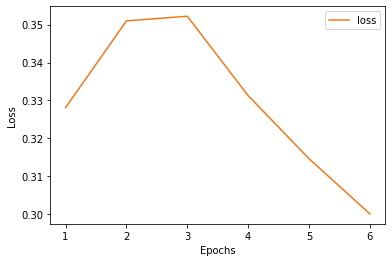

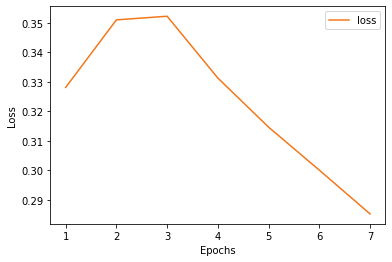

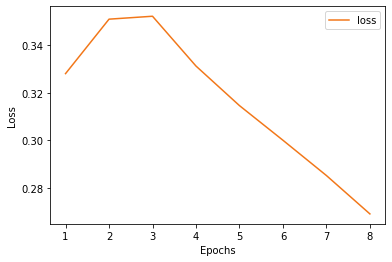

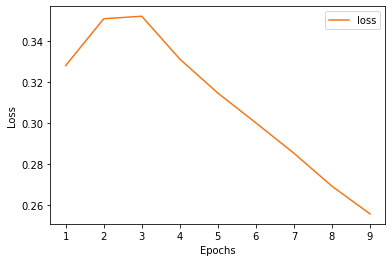

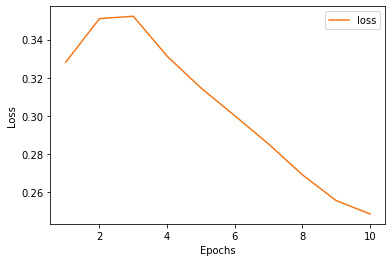

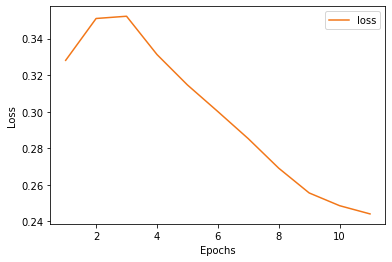

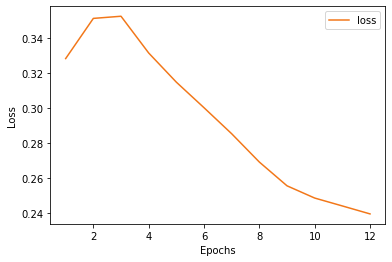

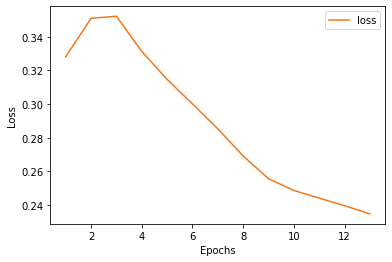

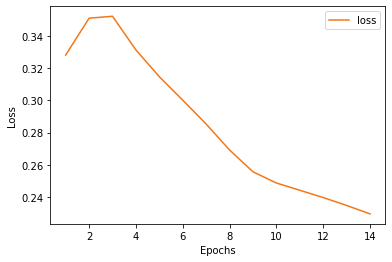

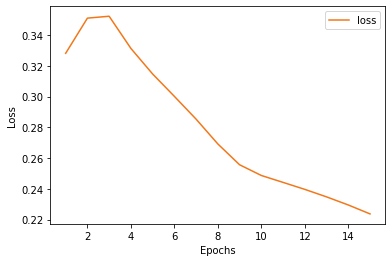

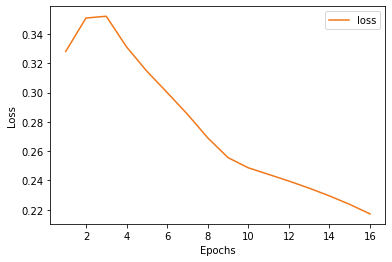

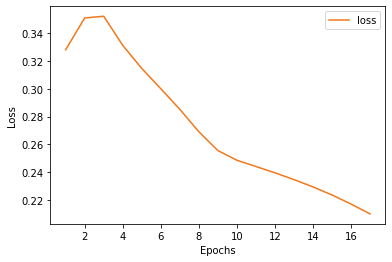

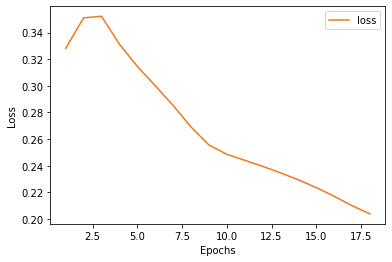

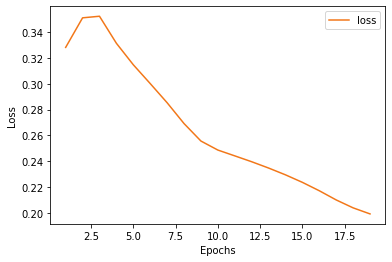

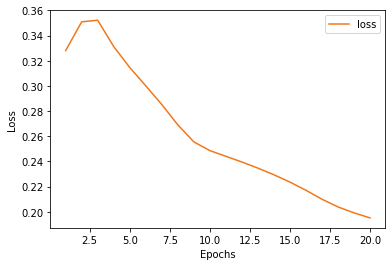

In [ ]:
train(network, cross_entropy, cross_entropy_prime, x_train, y_train, x_test, y_test, epochs=20, learning_rate=0.001)